<a href="https://colab.research.google.com/github/Nachtr/StockPred/blob/main/StockPred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Stock Prediction Project

In [38]:
!pip install ta streamlit

In [57]:
#Import libs
import os
import pandas as pd
import numpy as np
from pkg_resources import non_empty_lines
import joblib
import io


#indicators
from ta.momentum import RSIIndicator, StochasticOscillator, ROCIndicator, WilliamsRIndicator
from ta.trend import MACD, ADXIndicator, EMAIndicator, CCIIndicator, AroonIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator, MFIIndicator

#ML stuffs
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.ensemble import VotingClassifier

# Visual + Warn
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Finance data
import yfinance as yf
from datetime import datetime


warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Overwriting app.py


In [58]:
# Configs from necessary research

TICKERS = [ # I decided to remove tesla since its movement is usually based on the CEO and news...
    'SPY', # INDEX
    'QQQ',
    'AAPL', # Heavy hitter for S&P
    'NVDA',
    'MSFT', # Heavy hitter for S&P
    'JPM',
    'AMZN', # Heavy hitter for S&P
    'XOM',
    'BAC',
    'JNJ'
]

# For our start dates, we are going to go back 10 years.

START_DATE = '2013-01-01'
END_DATE = '2025-05-05'

# 5 day forward predictions
PREDICTION_HORIZON = 5

# Cross-Val
N_SPLITS = 5

# Gap
GAP = 5


# Configs for graphs
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [59]:
# Helper functions

def download_stock_data(ticker, start, end):
    try:
        print(f"Downloading {ticker} data from {start} to {end}...")
        # DEBUG: Added multi_level_index=False to prevent 2D shape errors
        df = yf.download(ticker, start=start, end=end, auto_adjust=True, progress=False, multi_level_index=False)

        if df.empty:
            print(f"No data available for {ticker}...")
            return None

        # Flatten columns if yfinance returns a MultiIndex
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)

        return df
    except Exception as e:
        print(f"Error downloading {ticker}: {str(e)}")
        return None


def add_tier1_indicators(df): # these will provide 80% of our predictive power
    # RSI is what 90% of traders use. This stands for relative strength index
    df['rsi'] = RSIIndicator(close = df['Close'], window = 14).rsi()

    # MACD is the next ind we plan to implement.
    macd = MACD(close=df['Close'], window_slow=26, window_fast=12, window_sign=9)
    df['macd_line'] = macd.macd()
    df['macd_signal'] = macd.macd_signal()
    df['macd_hist'] = macd.macd_diff()

    # Bollinger Bands
    bb = BollingerBands(close=df['Close'], window=20, window_dev = 2)
    df['bb_width'] = bb.bollinger_wband()
    df['bb_percent'] = bb.bollinger_pband()

    # ADX (Average Directional Index)
    adx = ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=14)
    df['adx'] = adx.adx()
    df['adx_pos'] = adx.adx_pos()
    df['adx_neg'] = adx.adx_neg()
    df['adx_diff'] = df['adx_pos'] - df['adx_neg'] # this is our directional component for better analysis

    # ATR (Average True Range)
    atr = AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'], window=14)
    df['atr_norm'] = atr.average_true_range() / df['Close']

    # This one must be normalized ^^^
    # These should be about 10 features


    return df

def add_tier2_indicators(df):
    # These are recommended indicators that will increase accuracy and add diversity to the set
    # This should add around 8 features

    # Stoch Osci
    stoch = StochasticOscillator(high=df['High'], low=df['Low'], close=df['Close'], window=14, smooth_window=3)
    df['stoch_k'] = stoch.stoch()
    df['stoch_d'] = stoch.stoch_signal()


    # OBV (on balance volume) - This is should use rate of change and not absolute
    obv = OnBalanceVolumeIndicator(close = df['Close'], volume = df['Volume'])
    df['obv_roc'] = obv.on_balance_volume().pct_change(5)

    # Williams %R
    df['williams_r'] = WilliamsRIndicator(high=df['High'], low=df['Low'], close = df['Close'], lbp = 14).williams_r()

    # EMA
    ema_12 = EMAIndicator(close = df['Close'], window=12).ema_indicator()
    ema_26 = EMAIndicator(close = df['Close'], window=26).ema_indicator()
    df['ema_ratio'] = ema_12 / ema_26

    # ROC (Rate of Change)
    df['roc_5'] = ROCIndicator(close = df['Close'], window = 5).roc()
    df['roc_10'] = ROCIndicator(close = df['Close'], window = 10).roc()
    return df

def add_tier3_indicators(df):
    # these are optional extra that will add 6 additional features to help improve acc

    # CCI Comod chan index
    df['cci'] = CCIIndicator(high = df['High'], low = df['Low'], close = df['Close'], window = 20).cci()

    # MFI money flow index
    df['mfi'] = MFIIndicator(high = df['High'], low = df['Low'], close = df['Close'], volume = df['Volume'], window = 14).money_flow_index()

    # Aroon Indic
    aroon = AroonIndicator(high=df['High'], low=df['Low'], window=25)
    df['aroon_indicator'] = aroon.aroon_indicator()

    return df

# I needed to add this here so that we can compare what happened 5 days ago vs this frame...
def add_lagged_features(df):
  target_features = ['rsi', 'macd_hist', 'adx_diff', 'obv_roc']

  for col in target_features:
    if col in df.columns:
      df[f'{col}_lag_5'] = df[col].shift(5)
      df[f'{col}_change_5'] = df[col] - df[f'{col}_lag_5']

  # Price momentum (returns)
  df['pct_change_3'] = df['Close'].pct_change(3)
  df['pct_change_5'] = df['Close'].pct_change(5)

  # Volatility context
  df['volatility_5'] = df['Close'].pct_change().rolling(5).std()
  return df

def add_all_indicators(df, tier = 'tier2'):
    # With this function we should make sure to add technical indicators based on the tier that is selected

    '''
    :param tier: tier1 (10 feat)
    :param tier: tier2 (18 feat)
    :param tier: tier3 (24 feat)
    '''

    df = add_tier1_indicators(df)

    if tier in ['tier2', 'tier3']:
        df = add_tier2_indicators(df)
    if tier == 'tier3':
        df = add_tier3_indicators(df)

    df = add_lagged_features(df)

    return df

def create_target_var(df, horizon=5):
    # We need to have a function that creates a binary target. If price goes up compared to the horizon days, return 1.

    df['target'] = (df['Close'].shift(-horizon) > df['Close']).astype(int)
    return df

def get_feature_columns(tier = 'tier2'):
    # Return feature column names based on the selected tier

    base_features = [
      'rsi',
      'macd_hist',
      'bb_width',
      'bb_percent',
      'adx_diff',
      'atr_norm',
      'rsi_change_5',
      'volatility_5',
      'pct_change_5'
    ]

    tier2_features = [
      'stoch_k',
      'obv_roc',
      'ema_ratio',
      'roc_10'
    ]

    tier3_features = [
      'cci',
      'mfi',
      'aroon_indicator'
    ]

    if tier == 'tier1':
        return base_features
    elif tier == 'tier2':
        return base_features + tier2_features
    else:
        return base_features + tier2_features + tier3_features

def check_feature_correlation(df, feature_cols, threshold=0.9):
    """
    With this function we need to check for highly correlated features and recommend removal. From my research document, I have found that correlation >9.9 should be avoided and removed.
    """

    corr_matrix = df[feature_cols].corr().abs()

    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > threshold:
                high_corr_pairs.append({
                    'feature1':corr_matrix.columns[i],
                    'feature2':corr_matrix.columns[j],
                    'correlation':corr_matrix.iloc[i, j]
                })

    if high_corr_pairs:
        print(f"\n High correlation pairs found (>{threshold})")
        for pair in high_corr_pairs:
            print(f" - {pair['feature1']} <-> {pair['feature2']}: {pair['correlation']:.3f}")
    else:
        print(f"\n No highly correlated features (>{threshold})")
    return high_corr_pairs

def train_xgboost_model(X_train, X_test, y_train, y_test, verbose=False):
    """
    Train with XGBoost with reg params
    """

    model = xgb.XGBClassifier(
        max_depth=6,
        min_child_weight=3,
        subsample=0.7,
        colsample_bytree=0.7,
        learning_rate=0.05,
        n_estimators=100,
        reg_lambda=1.0,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False,
    )

    model.fit(X_train, y_train, verbose=verbose)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return model, y_pred, accuracy

def train_random_forest_model(X_train, X_test, y_train, y_test):
    """
    Train with random forest with reg params
    :param X_train:
    :param X_test:
    :param y_train:
    :param y_test:
    :return:
    """

    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return model, y_pred, accuracy

def train_and_evaluate(df, ticker, tier='tier2', model_type='xgboost'):
    # Train model with time-series cross val and comp eval
    feature_cols = get_feature_columns(tier)
    df_clean = df.dropna()

    print(f"\nTraining ENSEMBLE (XGB + RF) for {ticker}...")

    tscv = TimeSeriesSplit(n_splits = N_SPLITS, gap = GAP)
    fold_accuracies = []
    feature_importances = []


    # Define the two models
    xgb_model = xgb.XGBClassifier(
        max_depth=6,
        learning_rate = 0.05,
        n_estimators = 100,
        eval_metric = 'logloss',
        use_label_encoder = False,
        random_state = 42
    )

    rf_model = RandomForestClassifier(
        n_estimators = 100,
        max_depth = 8,
        min_samples_leaf=4,
        random_state = 42,
        n_jobs = -1
    )

    # Voting Ensemble
    ensemble = VotingClassifier(
        estimators = [('xgb', xgb_model), ('rf', rf_model)],
        voting = 'soft'
    )

    for train_idx, test_idx in tscv.split(df_clean):
      X_train = df_clean.iloc[train_idx][feature_cols]
      y_train = df_clean.iloc[train_idx]['target']
      X_test = df_clean.iloc[test_idx][feature_cols]
      y_test = df_clean.iloc[test_idx]['target']

      # Scale
      scaler = StandardScaler()
      X_train_scaled = scaler.fit_transform(X_train)
      X_test_scaled = scaler.transform(X_test)

      # Train Ensemble
      ensemble.fit(X_train_scaled, y_train)

      # Prediction
      y_pred = ensemble.predict(X_test_scaled)
      acc = accuracy_score(y_test, y_pred)
      fold_accuracies.append(acc)

      # Extract Feature Importance
      feature_importances.append(ensemble.named_estimators_['rf'].feature_importances_)

    avg_acc = np.mean(fold_accuracies)
    print(f"Average Accuracy: {avg_acc:.4f}")

    # Final Training
    scaler_final = StandardScaler()
    X_all_scaled = scaler_final.fit_transform(df_clean[feature_cols])
    ensemble.fit(X_all_scaled, df_clean['target'])

    return {
        'ticker': ticker,
        'model_type': model_type,
        'tier': tier,
        'model': ensemble,
        'avg_accuracy': avg_acc,
        'fold_accuracies': fold_accuracies,
        'feature_importance': dict(zip(feature_cols, np.mean(feature_importances, axis = 0))),
        'min_accuracy': min(fold_accuracies),
        'max_accuracy': max(fold_accuracies),
        'std_accuracy': np.std(fold_accuracies)
    }



In [60]:
def plot_feature_importance(results, save_dir='./plots'):
    os.makedirs(save_dir, exist_ok=True)

    importance_df = pd.DataFrame([
        {'feature' : k, 'importance' : v}
        for k, v in results['feature_importance'].items()
    ]).sort_values('importance', ascending=False)

    plt.figure(figsize=(12, 8))
    colors = sns.color_palette("viridis", len(importance_df))
    sns.barplot(data=importance_df, y='feature', x='importance', palette=colors)
    plt.title(f"Feature Importance - {results['ticker']} ({results['model_type'].upper()})\n"
              f"Accuracy: {results['avg_accuracy']*100:.2f}%", fontsize=14, fontweight='bold')
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()

    filename = f"{save_dir}/feature_importance_{results['ticker']}_{results['model_type']}.png"
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.close()

    return filename

def plot_accuracy_comparison(all_results, save_dir='./plots'):
    os.makedirs(save_dir, exist_ok=True)

    comparison_data = []
    for result in all_results:
        comparison_data.append({
            'Ticker': result['ticker'],
            'Accuracy': result['avg_accuracy'] * 100,
            'Model': result['model_type'].upper()
        })

    df_comp = pd.DataFrame(comparison_data)

    plt.figure(figsize=(14, 8))
    ax = sns.barplot(data=df_comp, x='Ticker', y='Accuracy', hue='Model', palette='Set2')

    plt.axhline(y=60, color='red', linestyle='--', linewidth=2, label='60% Target')

    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', padding=3)

    plt.title('Model Accuracy Comparison Across Stocks\n5-Day Price Direction Prediction',
              fontsize=14, fontweight='bold')
    plt.xlabel('Stock Ticker', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.legend(title='Model Type', fontsize=10)
    plt.ylim(40, max(df_comp['Accuracy'].max() + 5, 70))
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()

    filename = f"{save_dir}/accuracy_comparison.png"
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.close()

    return filename

def save_detailed_results(all_results, filename = 'detailed_results.csv'):
    detailed_data = []

    for result in all_results:
        for fold_num, fold_acc in enumerate(result['fold_accuracies'], 1):
            detailed_data.append({
                'Ticker': result['ticker'],
                'Model': result['model_type'],
                'Tier': result['tier'],
                'Fold': fold_num,
                'Accuracy': fold_acc * 100,
                'Average_Accuracy': result['avg_accuracy'] * 100,
                'Std_Dev': result['std_accuracy'] * 100,
                'Min_Accuracy': result['min_accuracy'] * 100,
                'Max_Accuracy': result['max_accuracy'] * 100
            })

    df = pd.DataFrame(detailed_data)
    df.to_csv(filename, index=False)
    print(f"\nDetailed results saved to: {filename}")

    return df

def print_final_summary(all_results):
    """Print comprehensive final summary."""
    print("\n" + "="*70)
    print("FINAL SUMMARY - ALL STOCKS")
    print("="*70)

    summary_data = []
    for r in all_results:
        summary_data.append({
            'Ticker': r['ticker'],
            'Model': r['model_type'].upper(),
            'Tier': r['tier'].upper(),
            'Avg Acc': f"{r['avg_accuracy']*100:.2f}%",
            'Std Dev': f"{r['std_accuracy']*100:.2f}%",
            'Min': f"{r['min_accuracy']*100:.2f}%",
            'Max': f"{r['max_accuracy']*100:.2f}%",
            'Target Met': '✓' if r['avg_accuracy'] >= 0.60 else '✗'
        })

    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))

    overall_avg = np.mean([r['avg_accuracy'] for r in all_results])
    overall_std = np.std([r['avg_accuracy'] for r in all_results])
    stocks_above_60 = sum(1 for r in all_results if r['avg_accuracy'] >= 0.60)

    print(f"\n{'='*70}")
    print(f"Overall Statistics")
    print(f"{'='*70}")
    print(f"Average Accuracy Across All Stocks: {overall_avg*100:.2f}% (±{overall_std*100:.2f}%)")
    print(f"Stocks Meeting 60% Target: {stocks_above_60}/{len(all_results)}")
    print(f"Best Performing Stock: {max(all_results, key=lambda x: x['avg_accuracy'])['ticker']} "
          f"({max(r['avg_accuracy'] for r in all_results)*100:.2f}%)")
    print(f"Worst Performing Stock: {min(all_results, key=lambda x: x['avg_accuracy'])['ticker']} "
          f"({min(r['avg_accuracy'] for r in all_results)*100:.2f}%)")

    if overall_avg >= 0.60:
        print(f"\nSuccess: Overall average EXCEEDS 60% target!")
    else:
        gap = (0.60 - overall_avg) * 100
        print(f"\nOverall average is {gap:.2f}% below 60% target")
        print(f"Recommendations:")
        print(f"   - Try tier3 indicators for more features")
        print(f"   - Test Random Forest model as alternative")
        print(f"   - Consider ensemble methods (combine XGBoost + RF)")

    return summary_df


In [44]:
# Additional helper functions

def add_trend_features(df, spy_feats):
  df = df.merge(spy_feats, left_index = True, right_index = True, how = 'left')
  sma_20 = df['Close'].rolling(window = 20).mean()
  df['Trend_Slope'] = (sma_20 - sma_20.shift(5)) / sma_20.shift(5)
  bb = BollingerBands(close = df['Close'], window = 20, window_dev = 2)
  df['BB_Width'] = bb.bollinger_wband()

  df = df.fillna(method = 'ffill').fillna(0)
  return df

def get_5day_features(tier = 'tier3'):
  base = get_feature_columns(tier)
  extra = ['Trend_Slope', 'BB_Width', 'SPY_RSI', 'SPY_Trend']
  return base + extra


Testing with main and creation of app!

In [45]:
PREDICTED_HORI = 5
CONFIDENCE_THRESHOLD = 0.70

print(f"Targeting: {len(TICKERS)} stocks | Horizon: {PREDICTED_HORI} Days...")
print(f"Confidence Threshold: {CONFIDENCE_THRESHOLD * 100}%")
print("-" * 50)

# download market context for better predictions
spy_context = download_stock_data('SPY', START_DATE, END_DATE)
spy_context['SPY_RSI'] = RSIIndicator(close = spy_context['Close'], window = 14).rsi()

# Is spy long-term uptrend?
spy_context['SPY_Trend'] = (spy_context['Close'] > spy_context['Close'].rolling(200).mean()).astype(int)
spy_features = spy_context[['SPY_RSI', 'SPY_Trend']].copy()

Targeting: 10 stocks | Horizon: 5 Days...
Confidence Threshold: 70.0%
--------------------------------------------------


In [46]:
# Additional helper functions

"""
I added this after I made the original model to try to push accuracy up to 60%
"""

def get_sniper_features(tier='tier3'):
    # We take the standard features and add Market Context
    base = get_feature_columns(tier)
    return base + ['SPY_RSI', 'SPY_Trend', 'Trend_Slope', 'BB_Width']

def add_market_context(df, spy_features):
    # Merges the SPY data into the individual stock data
    df = df.merge(spy_features, left_index=True, right_index=True, how='left')

    # Add Trend Slope
    sma_20 = df['Close'].rolling(window=20).mean()
    df['Trend_Slope'] = (sma_20 - sma_20.shift(5)) / sma_20.shift(5)

    # Add Volatility Squeeze
    bb = BollingerBands(close=df['Close'], window=20, window_dev=2)
    df['BB_Width'] = bb.bollinger_wband()

    return df.fillna(method='ffill').fillna(0)

def train_and_evaluate_sniper(df, ticker, tier='tier3'):
    # Config
    CONFIDENCE_THRESHOLD = 0.60
    feature_cols = get_sniper_features(tier)

    X = df[feature_cols]
    y = df['target']

    # Time Series Split (Gap=5 to prevent leakage)
    tscv = TimeSeriesSplit(n_splits=N_SPLITS, gap=5)

    # The Ensemble
    ensemble = VotingClassifier(
        estimators=[
            ('xgb', xgb.XGBClassifier(max_depth=4, learning_rate=0.03, n_estimators=150, eval_metric='logloss', random_state=42)),
            ('rf', RandomForestClassifier(n_estimators=150, max_depth=6, min_samples_leaf=5, random_state=42, n_jobs=-1))
        ],
        voting='soft'
    )

    # define pipeline
    training_pipeline = Pipeline([
        ('scaler', StandardScaler()), # scale
        ('ensemble', ensemble) # model
    ])

    # remove the rest of the steps that I completed manually

    base_accuracies = []
    high_conf_trades = 0
    high_conf_wins = 0
    feature_importances = []

    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Fit the pipeline directly...
        training_pipeline.fit(X_train, y_train)

        # Standard Accuracy
        y_pred = training_pipeline.predict(X_test)
        base_accuracies.append(accuracy_score(y_test, y_pred))

        # Sniper Accuracy (Confidence > 60%)
        probs = training_pipeline.predict_proba(X_test)[:, 1]

        for i, prob in enumerate(probs):
            actual = y_test.iloc[i]
            if prob > CONFIDENCE_THRESHOLD:
                high_conf_trades += 1
                if actual == 1: high_conf_wins += 1
            elif prob < (1 - CONFIDENCE_THRESHOLD):
                high_conf_trades += 1
                if actual == 0: high_conf_wins += 1

        # Extract Importance from RF part
        rf_step = training_pipeline.named_steps['ensemble'].named_estimators_['rf']
        feature_importances.append(ensemble.named_estimators_['rf'].feature_importances_)

    # Compile Results
    avg_base = np.mean(base_accuracies)
    sniper_acc = (high_conf_wins / high_conf_trades) if high_conf_trades > 0 else 0.5


    filename = f"{ticker}_sniper_pipeline.pkl"
    joblib.dump(training_pipeline, filename)
    print(f"  > Model saves to {filename}") # sidenote, but I decided to use this format out of habit because of my C++ course

    print(f"   > Base Acc: {avg_base:.1%} | Sniper Acc: {sniper_acc:.1%} ({high_conf_trades} trades)")

    return {
        'ticker': ticker,
        'model_type': 'Sniper_Ensemble',
        'tier': tier,
        'avg_accuracy': avg_base,       # Standard Accuracy
        'sniper_accuracy': sniper_acc,  # The High Confidence Accuracy
        'trades': high_conf_trades,
        'fold_accuracies': base_accuracies, # Needed for save function
        'std_accuracy': np.std(base_accuracies), # Needed for save function
        'min_accuracy': min(base_accuracies),
        'max_accuracy': max(base_accuracies),
        'feature_importance': dict(zip(feature_cols, np.mean(feature_importances, axis=0)))
    }

In [47]:
all_results = []

print("Starting Sniper Pipeline...")
print(f"Targeting: {len(TICKERS)} stocks | Horizon: {PREDICTION_HORIZON} days")
print("-" * 50)

# Download Market Context
print("Downloading SPY Context...")
spy_context = download_stock_data('SPY', START_DATE, END_DATE)
spy_context['SPY_RSI'] = RSIIndicator(close=spy_context['Close'], window=14).rsi()
spy_context['SPY_Trend'] = (spy_context['Close'] > spy_context['Close'].rolling(200).mean()).astype(int)
spy_features = spy_context[['SPY_RSI', 'SPY_Trend']].copy()

for ticker in TICKERS:
    try:
        # Download
        df = download_stock_data(ticker, START_DATE, END_DATE)

        # Check if data is valid
        if df is None or len(df) < 200:
            print(f"Skipping {ticker}: Insufficient data.")
            continue

        # Add Indicators
        try:
            df = add_all_indicators(df, tier='tier3')

            # Inject Market Context
            df = add_market_context(df, spy_features)

        except Exception as e:
            print(f"Error adding indicators for {ticker}: {e}")
            continue

        # Create Target
        df = create_target_var(df, horizon=PREDICTION_HORIZON)
        df = df.dropna()

        # Train & Evaluate using Sniper Function
        print(f"Training {ticker}...", end="")
        result = train_and_evaluate_sniper(df, ticker, tier='tier3')

        if result:
            all_results.append(result)
            try:
                plot_feature_importance(result)
            except Exception as e:
                print(f"Could not plot importance for {ticker}: {e}")

    except Exception as e:
        print(f"\nCRITICAL ERROR processing {ticker}: {str(e)}")
        continue

# Final Reporting
if all_results:
    print("\n" + "="*50)
    print("Generating Final Reports...")
    print("="*50)

    # Summary for Sniper Results
    print(f"\n{'Ticker':<6} | {'Base Acc':<10} | {'Sniper Acc (>60%)':<20} | {'Trades'}")
    print("-" * 65)
    for r in all_results:
        print(f"{r['ticker']:<6} | {r['avg_accuracy']:.1%}     | {r['sniper_accuracy']:.1%}               | {r['trades']}")

    try:
        save_detailed_results(all_results)
        plot_accuracy_comparison(all_results)
        print("\nExecution Complete! Check the './plots' folder for images.")
    except Exception as e:
        print(f"Error generating final reports: {e}")
else:
    print("\nNo results were generated. Please check your data connection and try again.")

Starting Sniper Pipeline...
Targeting: 10 stocks | Horizon: 5 days
--------------------------------------------------
Training SPY...  > Model saves to SPY_sniper_pipeline.pkl
   > Base Acc: 58.0% | Sniper Acc: 59.0% (1608 trades)
Training QQQ...  > Model saves to QQQ_sniper_pipeline.pkl
   > Base Acc: 56.8% | Sniper Acc: 58.5% (1616 trades)
Training AAPL...  > Model saves to AAPL_sniper_pipeline.pkl
   > Base Acc: 54.7% | Sniper Acc: 54.9% (1200 trades)
Training NVDA...  > Model saves to NVDA_sniper_pipeline.pkl
   > Base Acc: 55.1% | Sniper Acc: 56.2% (1594 trades)
Training MSFT...  > Model saves to MSFT_sniper_pipeline.pkl
   > Base Acc: 57.0% | Sniper Acc: 58.3% (1246 trades)
Training JPM...  > Model saves to JPM_sniper_pipeline.pkl
   > Base Acc: 52.6% | Sniper Acc: 53.7% (1200 trades)
Training AMZN...  > Model saves to AMZN_sniper_pipeline.pkl
   > Base Acc: 53.2% | Sniper Acc: 55.4% (1052 trades)
Training XOM...  > Model saves to XOM_sniper_pipeline.pkl
   > Base Acc: 51.0% | Sn

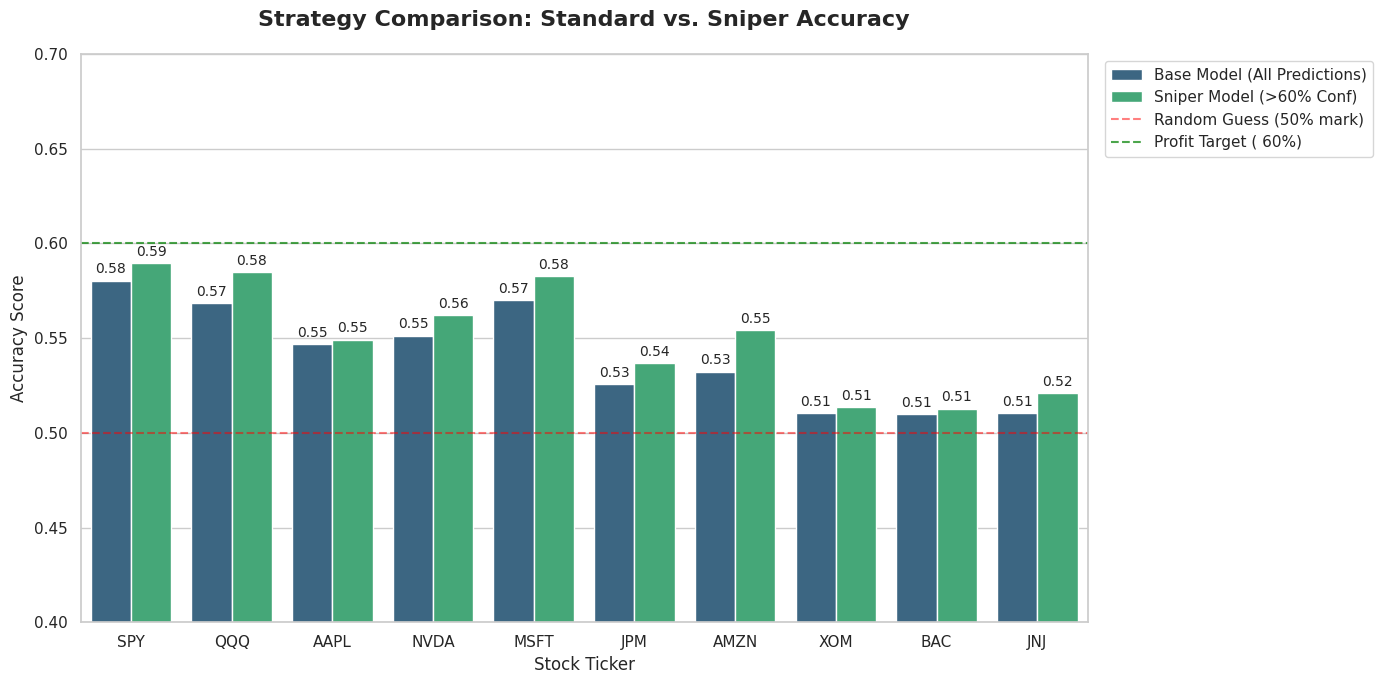

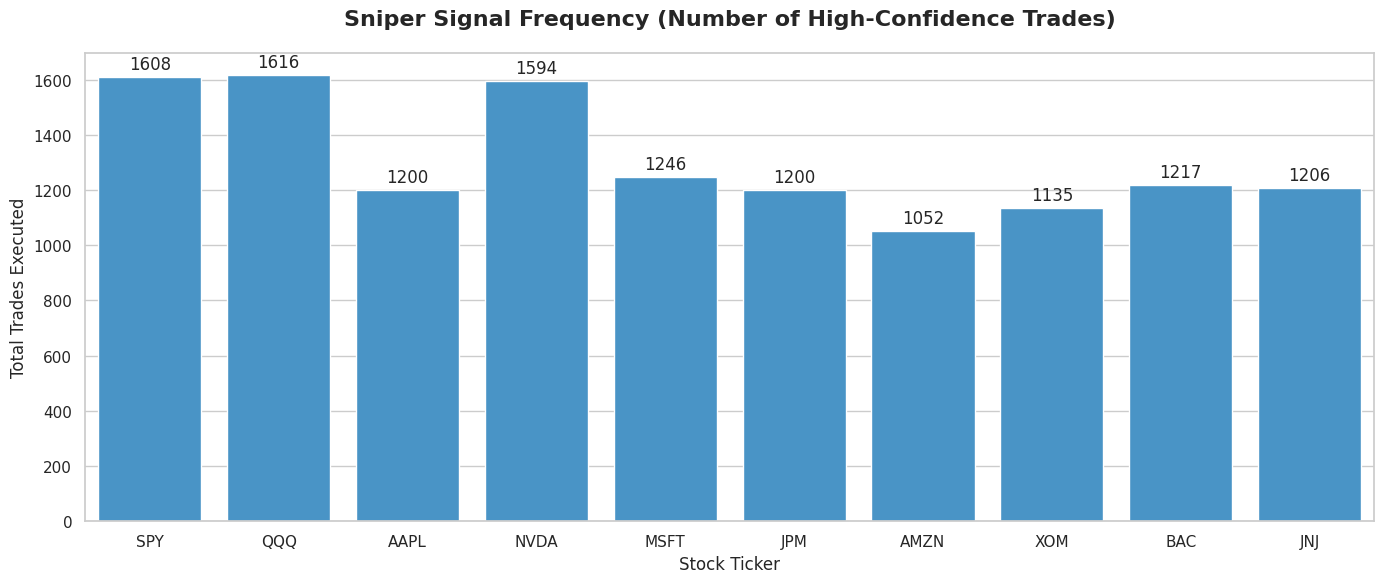

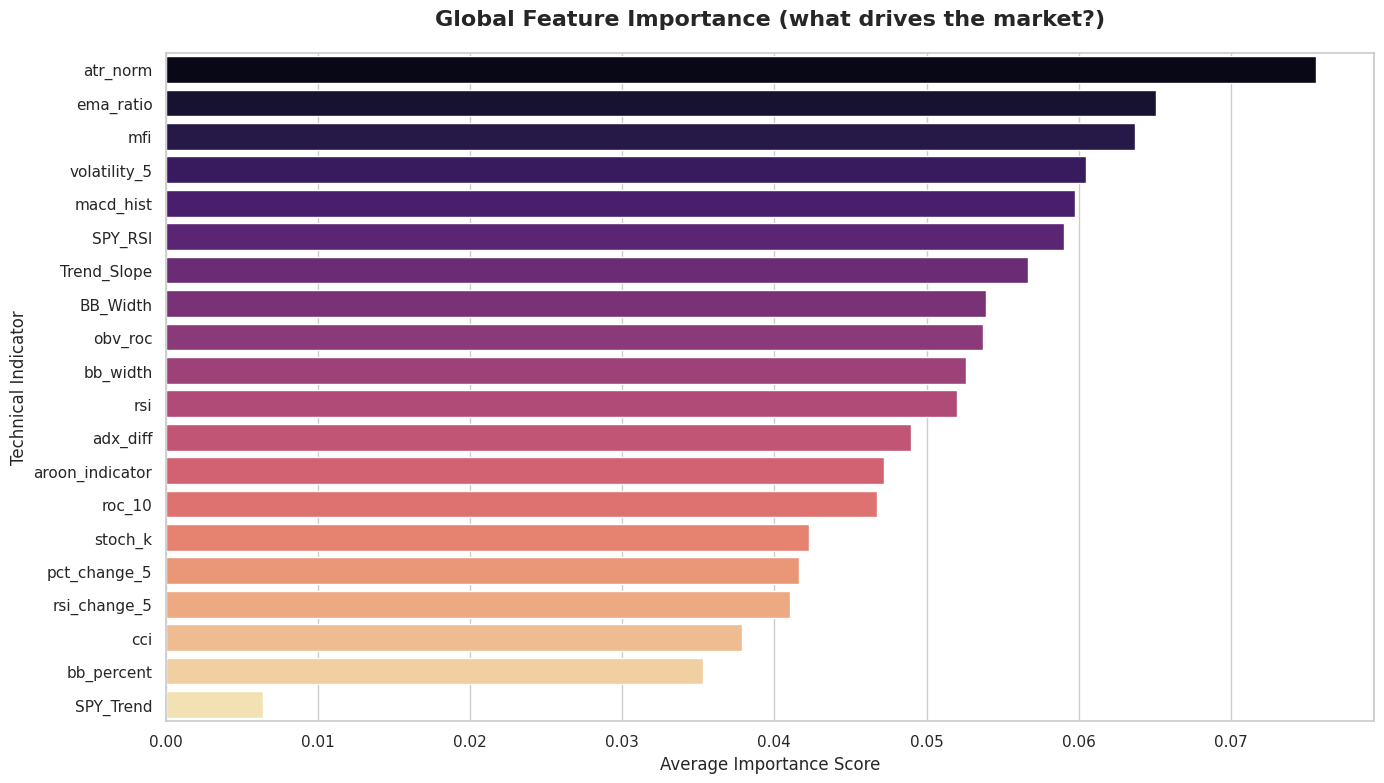

Generating Feature Correlation Heatmap (EDA Requirement)...


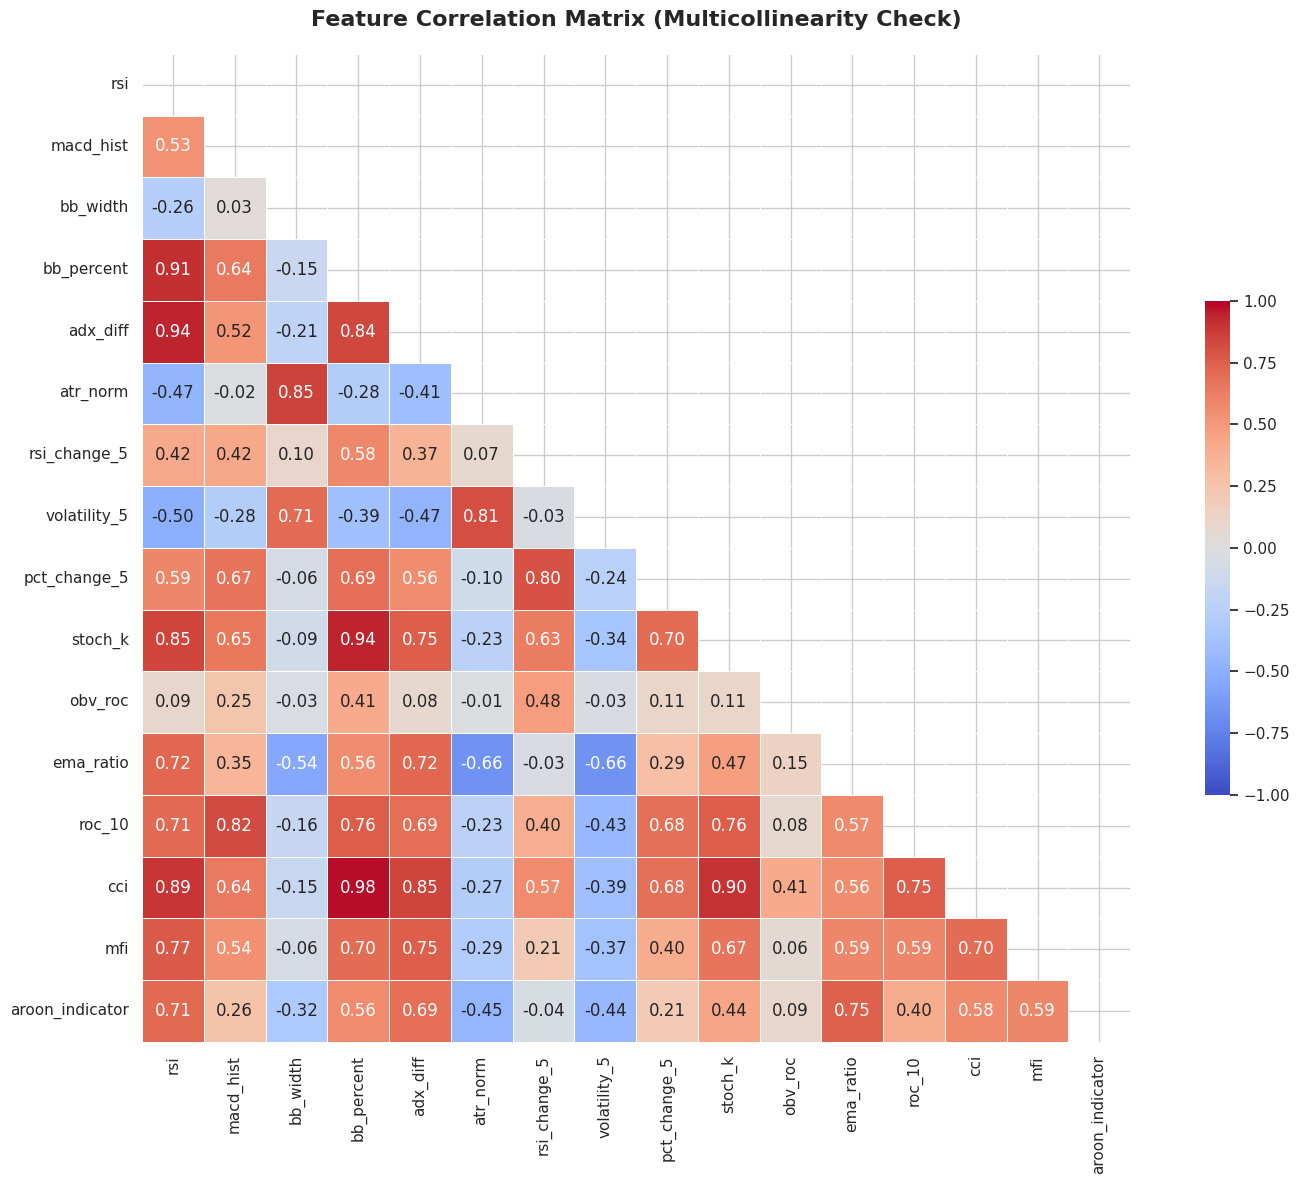

In [76]:
# Charting

sns.set_theme(style = "whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

def generate_project_charts(results_list):
  if not results_list:
    print("No results to chart. Please run the training loop first...")
    return

  # Acc Comp
  plot_data = []

  for r in results_list:
    plot_data.append({'Ticker': r['ticker'], 'Accuracy': r['avg_accuracy'], 'Type': 'Base Model (All Predictions)'})
    plot_data.append({'Ticker': r['ticker'], 'Accuracy': r['sniper_accuracy'], 'Type': 'Sniper Model (>60% Conf)'})

  df_acc = pd.DataFrame(plot_data)

  plt.figure(figsize = (14, 7))
  ax1 = sns.barplot(data = df_acc, x='Ticker', y='Accuracy', hue='Type', palette='viridis')

  plt.axhline(y = 0.5, color = 'red', linestyle = '--', alpha = 0.5, label = 'Random Guess (50% mark)')
  plt.axhline(y = 0.6, color = 'green', linestyle = '--', alpha = 0.7, label = 'Profit Target ( 60%)')

  # Labels
  plt.title('Strategy Comparison: Standard vs. Sniper Accuracy', fontsize = 16, fontweight = 'bold', pad = 20)
  plt.ylabel('Accuracy Score', fontsize = 12)
  plt.xlabel('Stock Ticker', fontsize = 12)
  plt.ylim(0.4, 0.7)
  plt.legend(bbox_to_anchor = (1.01, 1), loc = 'upper left')

  for container in ax1.containers:
    ax1.bar_label(container, fmt = '%.2f', padding = 3, fontsize = 10)

  plt.tight_layout()
  plt.savefig('accuracy_comparison.png', dpi = 300)
  plt.show()
  print("\n")


  # Trade Vol
  df_trades = pd.DataFrame(results_list)[['ticker', 'trades']]

  plt.figure(figsize = (14, 6))
  ax2 = sns.barplot(data = df_trades, x = 'ticker', y = 'trades', color = '#3498db')

  plt.title('Sniper Signal Frequency (Number of High-Confidence Trades)', fontsize = 16, fontweight = 'bold', pad = 20)
  plt.ylabel('Total Trades Executed', fontsize = 12)
  plt.xlabel('Stock Ticker', fontsize = 12)

  # Annotate
  ax2.bar_label(ax2.containers[0], padding = 3)

  plt.tight_layout()
  plt.savefig('trade_frequency.png', dpi = 300)
  plt.show()
  print("\n")


  # Aggregate Featire
  feat_data = []

  for r in results_list:
    for feat, score in r['feature_importance'].items():
      feat_data.append({'Feature': feat, 'Importance': score})

  df_feat = pd.DataFrame(feat_data)
  avg_feat_impt = df_feat.groupby('Feature')['Importance'].mean().sort_values(ascending = False).reset_index()

  plt.figure(figsize = (14, 8))
  sns.barplot(data = avg_feat_impt, x = 'Importance', y = 'Feature', palette = 'magma')

  plt.title('Global Feature Importance (what drives the market?)', fontsize = 16, fontweight = 'bold', pad = 20)
  plt.xlabel('Average Importance Score', fontsize = 12)
  plt.ylabel('Technical Indicator', fontsize = 12)

  plt.tight_layout()
  plt.savefig('feature_importance_global.png', dpi = 300)
  plt.show()

  print("Generating Feature Correlation Heatmap (EDA Requirement)...")
  df = download_stock_data('SPY', START_DATE, END_DATE)
  df = add_all_indicators(df, tier = 'tier3')
  feature_cols = get_feature_columns('tier3')
  corr_matrix = df[feature_cols].corr()

  plt.figure(figsize = (16, 12))
  mask = np.triu(np.ones_like(corr_matrix, dtype = bool))

  sns.heatmap(corr_matrix,
              mask = mask,
              annot = True,
              fmt = ".2f",
              cmap = 'coolwarm',
              vmin = -1,
              vmax = 1,
              center = 0,
              square = True,
              linewidths = .5,
              cbar_kws = {"shrink": .5})

  plt.title('Feature Correlation Matrix (Multicollinearity Check)', fontsize = 16, fontweight = 'bold', pad = 20)
  plt.tight_layout()
  plt.savefig('feature_correlation.png', dpi = 300)
  plt.show()

generate_project_charts(all_results)




Chart #1:
The goal of this chart is to compare the accuracy off the "Base Model" vs our "Sniper Strategy" that we have developed.

We can observe that the green bars (sniper performance) consistently outperform or match the blue bars (the base) across the majority of tickers selected. Most notably of our results, we can see that the SPY and QQQ tickers performed the best with our prediction algorithm.

Some insight we can gather from this chart is that when we apply a high-confidence filter we can improve our win rate. The data suggests that our model with the sniper training significantly outperforms our base model's performance. This is likely because indicies representing aggregated market sintiment and are less susceptible noise from CEO changes, earnings misses, or bad press. These factors often cause erratic price fluctuations.

Chart #2: Through this chart we can see that there is high volume between 1050 and 1616 trades per ticker over the 12-year period. The model tended to do better on SPY and QQQ and high momentum stocks like NVDA. Defensive stocks like JNJ or XOM tended to trigger fewer signals.

What we can gather from all of this is that the model has an active momentum bias and clearly favors high beta assets (tech, index, etc...). The model likes assets that trend strongly, and dont jump around. We can also gather that the model prefers to swing trade rather than buy and hold like standard models.

Chart #3:
In this chart we can observe that atr_norm which is Normalized Average True range is the most important feature. This is along with vol_5 and BB_width. The second most important feature is ema_ration which measures the relationships between short and long-term moving averages. The result indicates strength in trending up or down.

A key insight that we can gather from all of this is that the sniper strategy that we have deployed overwhelmingly favors breakout in volatility or regime.  The model has learned specifically through its training that the magnitude of price performance is a much better predictor of future direction than the actual price itself.

We also learn from this chart that the model isnt trading in a vacuum like most traders are. Instead its training in a holistic environment which allows it to ask the necessary questions before entering a trade and without prior knowledge unlike human traders.

Chart 4: Lastly, we can see from the matrix that volatility is still one of the most dominant factors. Additionally the model is emplying volume confirmation to help reinforce its decisions.

We can gather from this chart basically everything we gathered from the last chart. It basically can be used to reinforce our results which is a good thing.

